In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = [15, 10]

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data=pd.read_csv('Telefonia_movil.csv', parse_dates=True, dayfirst=True)
""" muestra 
Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
"""
data['Q'] = data.agg('{0[Año]}Q{0[Trimestre]}'.format, axis=1)
data = data.drop(columns=['Año', 'Trimestre', 'Periodo'])
data.rename(columns = {"Minutos pospago salientes (miles)": "pospago_saliente", 
                     "Minutos prepago salientes (miles)":"prepago_saliente",
                     "Total de minutos salientes (miles)": "total"}, inplace = True) 
# matar ese punto por un camino corto
data['pospago_saliente'] = data['total'] - data['prepago_saliente']
data = data[['Q', 'pospago_saliente', 'prepago_saliente', 'total']]
data['Q'] = pd.to_datetime(data['Q']).dt.to_period('Q')
data = data.set_index('Q')
data.tail()

,pospago_saliente,prepago_saliente,total
Q,,,
2018Q1,13423580,5850985,19274565
2018Q2,14240217,6027374,20267591
2018Q3,14574305,6108477,20682782
2018Q4,14915060,6613685,21528745
2019Q1,13937271,6427084,20364355


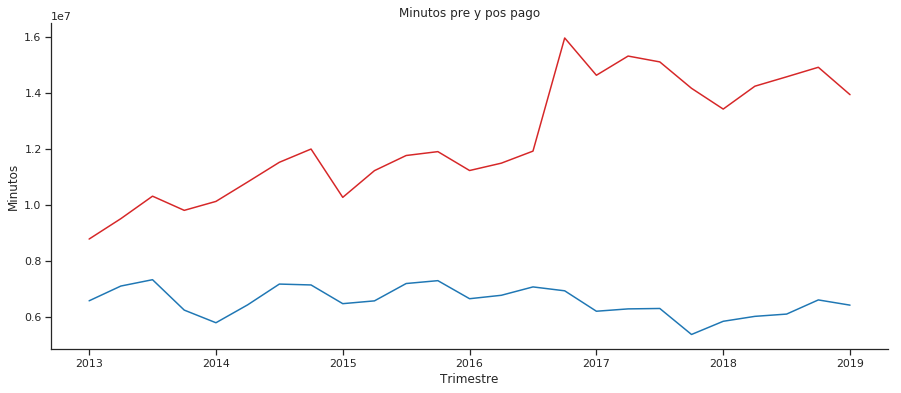

In [3]:
y1=data['pospago_saliente']
y2=data['prepago_saliente']

# ## Exploratory data analysis
# 
# The first step in our analysis is a time series plot. We can see that both the level and volatility of inflation is much lower in recent times than it was in the 80s. There is a noticeable outlier in the third quarter of 2000 due to introduction of the GST in Australia. 

fig, ax= plt.subplots(figsize=(15,6))
y1.plot(color=red)
y2.plot(color=blue)
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos')
ax.set_title('Minutos pre y pos pago')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [4]:
data.describe().round(2)

,pospago_saliente,prepago_saliente,total
count,25.00,25.0,25.00
mean,12359295.32,6562909.4,18922204.72
std,2085582.22,516860.4,1982378.31
min,8785943.00,5380710.0,15368060.00
25%,10821463.00,6250549.0,17650638.00
50%,11905072.00,6579819.0,19001229.00
75%,14240217.00,7077838.0,20364355.00
max,15960764.00,7335154.0,22899656.00


In [5]:
# ## Random walk
# 
# In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 
# 
# 1. Specify the forecast horizon.
# 
# 2. Create a range of dates or periods starting from the time index following the last observation in the data. 
# 
# 3. Generate the forecasts and store them in a series indexed by step 2. 
# 
# Below, we generate point forecasts for one to four quarters after the end of the series. 

h = 4
test1 = pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
pred1 = pd.Series(np.repeat(y1.iloc[-1], h), index=test1) # the forecast repeats the last observed values h times

test2 = pd.period_range(start=y2.index[-1]+1, periods=h, freq='Q')
pred2 = pd.Series(np.repeat(y2.iloc[-1], h), index=test2) # the forecast repeats the last observed values h times

print(f'Predicción Randon Walk para pospago \n{pred1}')
print(f'Predicción Randon Walk para prepago \n{pred2}')


Predicción Randon Walk para pospago 
2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64
Predicción Randon Walk para prepago 
2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64


In [6]:
# the shift lags the series by one period
resid1 = y1 - y1.shift(1)
sigma1 = resid1.std()
s1 = round(sigma1,3)

resid2 = y2 - y2.shift(1)
sigma2 = resid2.std()
s2 = round(sigma2,3)

print(f'Sigma pospago: {s1}')
print(f'Sigma prepago: {s2}')

Sigma pospago: 1111026.733
Sigma prepago: 510832.977


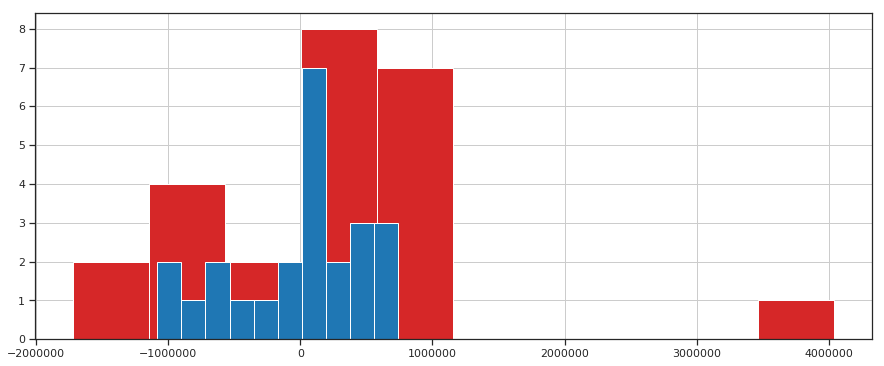

In [7]:
#Debe ser normal para que es ande, mirar
resid1.hist(figsize=(15,6), color=red, label='Pospago')
resid2.hist(figsize=(15,6), color=blue, label='Prepago')

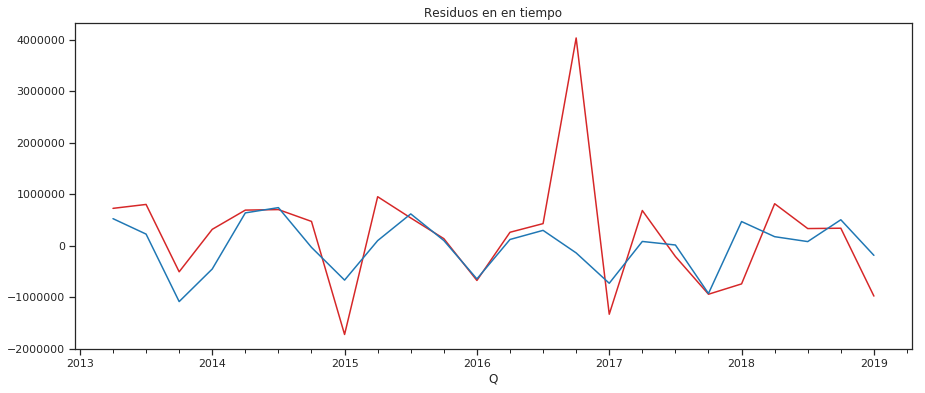

In [8]:
# ver como se mueven estos residuos en el tiempo (esperamos no ver tendencias)
resid1.plot.line(figsize=(15,6), title='Residuos en en tiempo', color=red, label='Pospago')
resid2.plot.line(figsize=(15,6), color=blue, label='Prepago')

In [9]:
intv1 = pd.concat([pred1 - stats.norm.ppf(0.975) * sigma1 * np.sqrt(np.arange(1, h+1)),
                   pred1 + stats.norm.ppf(0.975) * sigma1 * np.sqrt(np.arange(1, h+1))], 
                   axis=1)
intv1.round(3)

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582126e+06,1.829242e+07


In [10]:
intv2 = pd.concat([pred2 - stats.norm.ppf(0.975) * sigma2 * np.sqrt(np.arange(1, h+1)),
                   pred2 + stats.norm.ppf(0.975) * sigma2 * np.sqrt(np.arange(1, h+1))], 
                   axis=1)
intv2.round(3)

,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


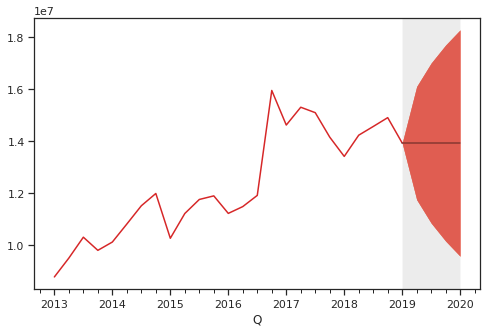

In [11]:
from plotting import fanchart

point_pred = (intv1[0] + intv1[1]) / 2
fig, ax = fanchart(y1['2010':], point_pred, intv1, intv1, intv1)

plt.show()

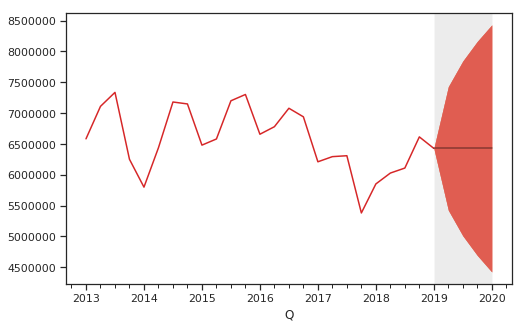

In [12]:
point_pred = (intv2[0] + intv2[1]) / 2
fig, ax = fanchart(y2['2010':], point_pred, intv2, intv2, intv2)

plt.show()

In [13]:
# ## Simple exponential smoothing
# 
# The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
# holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

print('Pospago')
model_ses1 = sm.tsa.SimpleExpSmoothing(y1).fit()
fitted_ses1 = model_ses1.fittedvalues
model_ses1.summary()

Pospago


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28378880925878.910
Optimized:,True,AIC,697.945
Trend:,None,BIC,700.383
Seasonal:,None,AICC,699.945
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,18:12:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7855887,alpha,True
initial_level,8.829e+06,l.0,True


In [14]:
print('Prepago')
model_ses2 = sm.tsa.SimpleExpSmoothing(y2).fit()
fitted_ses2 = model_ses2.fittedvalues
model_ses2.summary()

Prepago


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,5830131845625.864
Optimized:,True,AIC,658.380
Trend:,None,BIC,660.817
Seasonal:,None,AICC,660.380
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,18:12:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4350915,alpha,True
initial_level,6.7731e+06,l.0,True


In [15]:
# Also AIC and BIC looks off so we are continue our analysis with MSE.

mse_ses1 = sm.tools.eval_measures.mse(y1,fitted_ses1)
print(' In-sample fit POSPAGO:')
print(' MSE               {0:.3f}'.format(mse_ses1))

mse_ses2 = sm.tools.eval_measures.mse(y2,fitted_ses2)
print(' In-sample fit PREPAGO:')
print(' MSE               {0:.3f}'.format(mse_ses2))


 In-sample fit POSPAGO:
 MSE               1135155237035.156
 In-sample fit PREPAGO:
 MSE               233205273825.035


In [16]:
# You can calculate AIC and BIC as follows

N1 = len(y1)
loglik_ses1=-(N1/2)*(1+np.log(2*np.pi))-(N1/2)*np.log(mse_ses1)
aic_ses1=-2*loglik_ses1+2*3
bic_ses1=-2*loglik_ses1+np.log(N1)*3
print('POSPAGO')
print(' Log-likelihood   %.3f' % (loglik_ses1))
print(' AIC               {0:.3f}'.format(aic_ses1))
print(' BIC               {0:.3f}'.format(bic_ses1))


N2 = len(y2)
loglik_ses2= -(N2/2) * (1+np.log(2 * np.pi)) - (N2/2)*np.log(mse_ses2)
aic_ses2 = -2 * loglik_ses2 + 2 * 3
bic_ses2 = -2 * loglik_ses2 + np.log(N2) * 3
print('PREPAGO')
print(' Log-likelihood    %.3f' % (loglik_ses2))
print(' AIC               {0:.3f}'.format(aic_ses2))
print(' BIC               {0:.3f}'.format(bic_ses2))


POSPAGO
 Log-likelihood   -382.446
 AIC               770.892
 BIC               774.548
PREPAGO
 Log-likelihood    -362.663
 AIC               731.327
 BIC               734.983


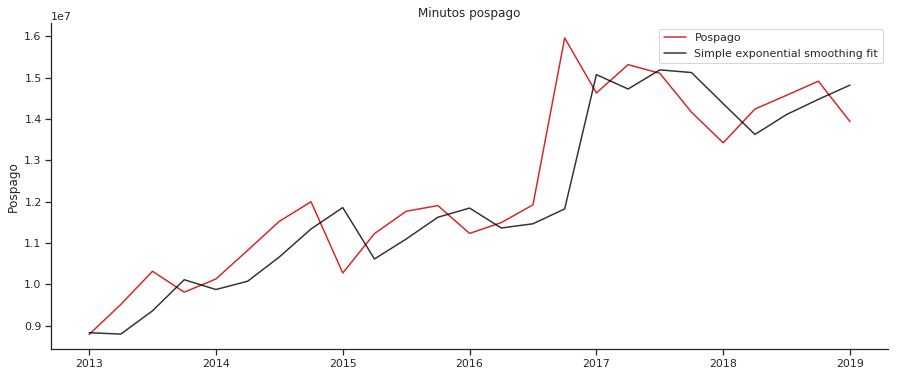

In [17]:
# Now, let's see how the smoothed data fits the original data

fig, ax= plt.subplots(figsize=(15,6))
y1.plot(color=red, label='Pospago')
fitted_ses1.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Pospago')
ax.set_title('Minutos pospago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

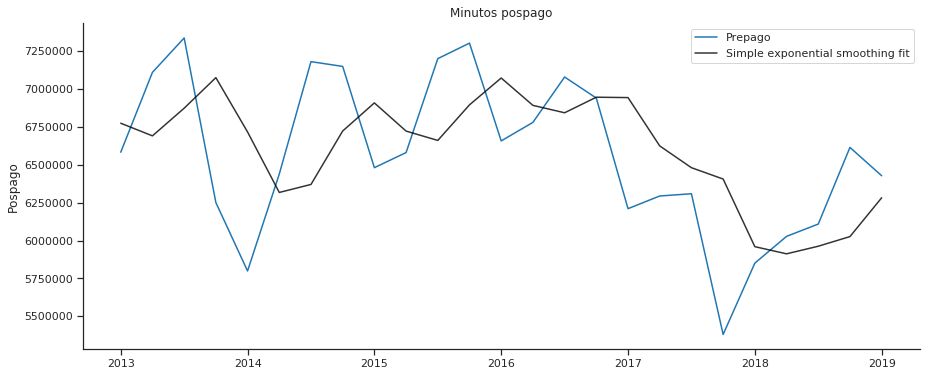

In [18]:
fig, ax= plt.subplots(figsize=(15,6))
y2.plot(color=blue, label='Prepago')
fitted_ses2.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Pospago')
ax.set_title('Minutos pospago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [19]:
# ## Model diagnostics
# 
# We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 
# 
# 1. Residual plot.
# 2. Residual autocorrelation function (ACF) plot.
# 3. Residual distribution plots.
# 
# We compute the residuals as follows.

resid1 = y1 - fitted_ses1 # model_ses.resid isn't a panda.Series, so no index, no plot
resid2 = y2 - fitted_ses2 # model_ses.resid isn't a panda.Series, so no index, no plot

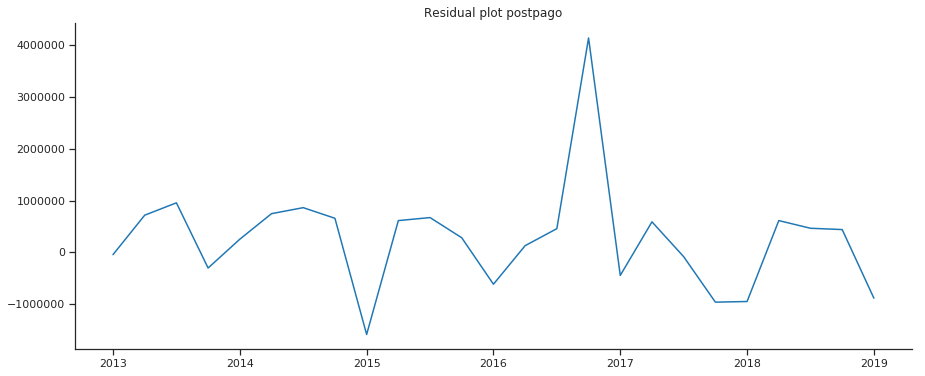

In [20]:
# The following cells compute the diagnostics. 
# We find that the residuals are uncorrelated, have non-constant
# variance (due to higher volatitility in the 80s), and are non-Gaussian. 

fig, ax= plt.subplots(figsize=(15,6))
resid1.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot postpago')
sns.despine()
plt.show()

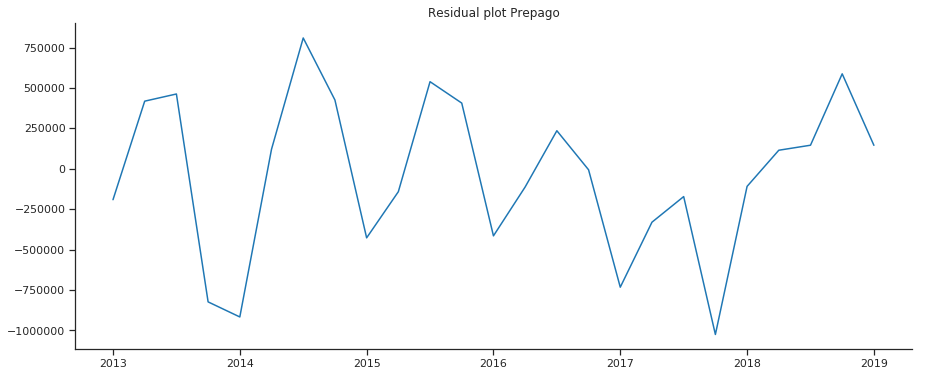

In [21]:
fig, ax= plt.subplots(figsize=(15,6))
resid2.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Prepago')
sns.despine()
plt.show()

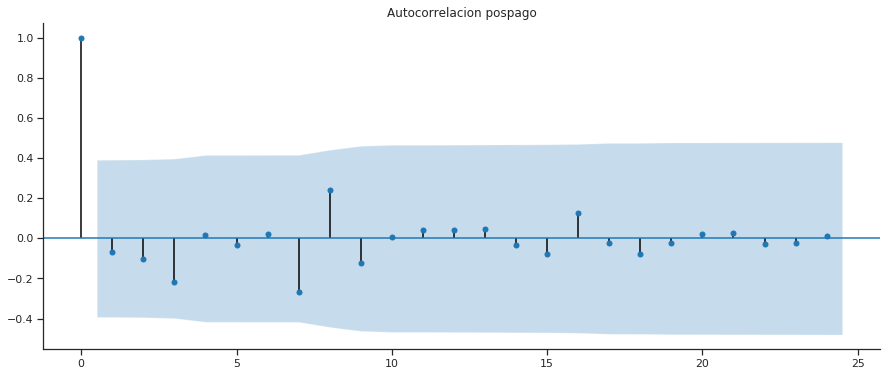

In [22]:
# Next is the residual ACF plot aka correlogram

fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(resid1, lags=24, ax=ax, title='Autocorrelacion pospago')
sns.despine()
plt.show()

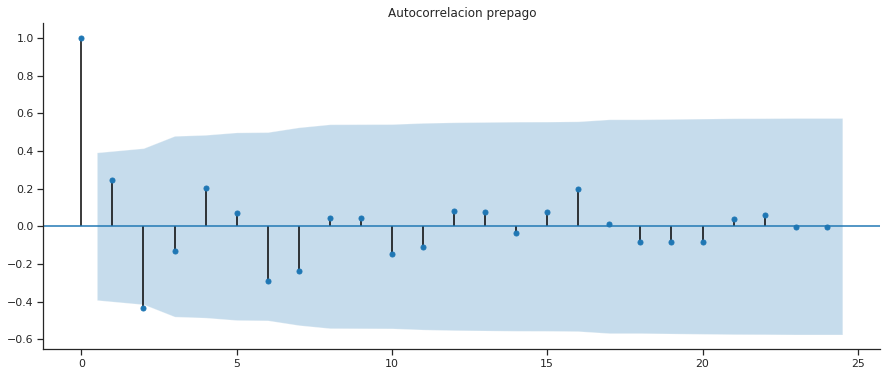

In [23]:
# Next is the residual ACF plot aka correlogram

fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(resid2, lags=24, ax=ax, title='Autocorrelacion prepago')
sns.despine()
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


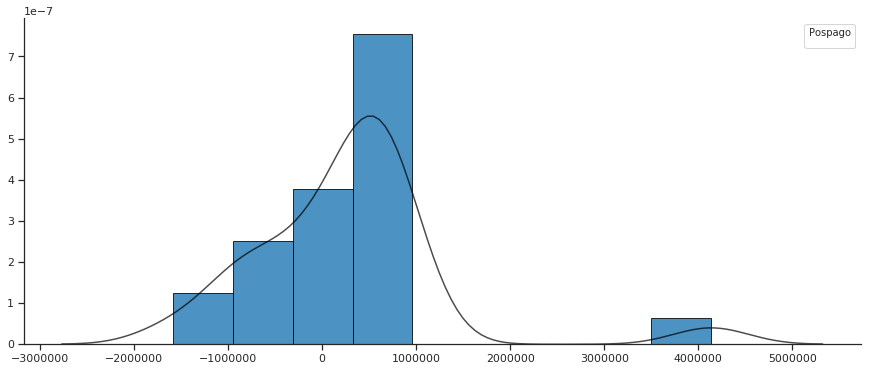

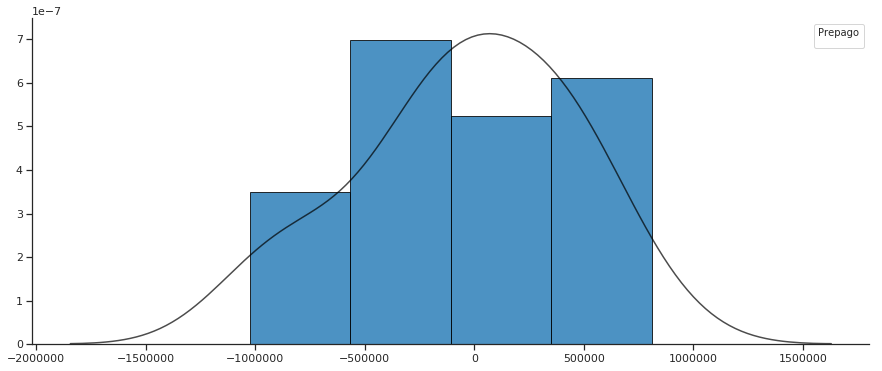

In [24]:

# Plotting histogram (in blue) and kernel density estimation (in black) for the residuals
def hist(series, title):
    fig, ax= plt.subplots(figsize=(15,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    l = ax.legend()
    l.set_title(title)
    return fig, ax

hist(resid1, title='Pospago')
hist(resid2, title='Prepago')
plt.show()

        Random Walk  Simple Exponential Smoothing      Actual
Q                                                            
2017Q1   15960764.0                   15960764.00  14630269.0
2017Q2   14630269.0                   14720102.94  15315167.0
2017Q3   15315167.0                   15186116.20  15106274.0
2017Q4   15106274.0                   15123933.70  14164552.0
2018Q1   14164552.0                   14372946.58  13423580.0
2018Q2   13423580.0                   13590289.21  14240217.0
2018Q3   14240217.0                   14110282.70  14574305.0
2018Q4   14574305.0                   14480809.43  14915060.0
2019Q1   14915060.0                   14831921.61  13937271.0


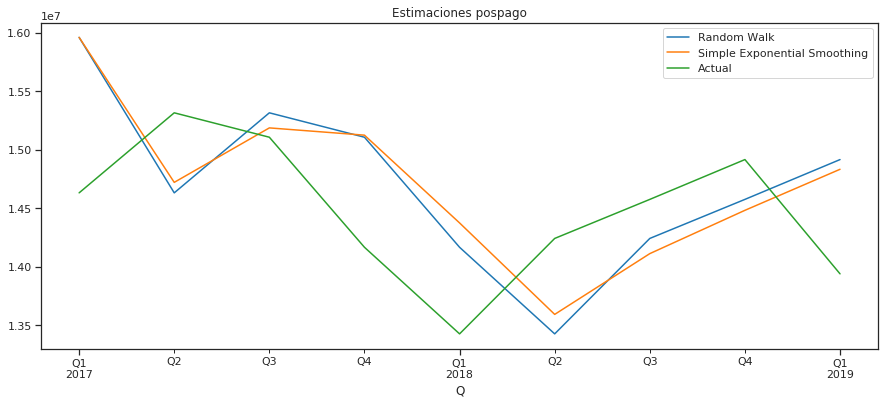

In [50]:
validation_starts = '2017Q1'

# ## Model validation (y1: pospago)
# 
# We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

# Real time forecasting - use it as a template - expanding window

validation1 = y1[validation_starts:].index # the validation period is Q1 2004 onwards
start1 = y1.index.get_loc(validation_starts) # numerical index corresponding to Q1 2005

pred1_1 = []
pred1_2 = []
actual1 = []
for i in range(start1, len(y1)):
    actual1.append(y1.iloc[i]) # actual value
    pred1_1.append(y1.iloc[i-1]) # random walk forecast
    model1 = sm.tsa.SimpleExpSmoothing(y1.iloc[:i]).fit() 
    pred1_2.append(model1.forecast(1)[0]) # SES forecast

columns1=['Random Walk', 'Simple Exponential Smoothing', 'Actual']
results_sm1 = np.vstack([pred1_1, pred1_2, actual1]).T
results_sm1 = pd.DataFrame(results_sm1, columns=columns1, index=validation1)
print(results_sm1.round(2))

results_sm1.plot.line(figsize=(15,6), title='Estimaciones pospago', label='Pospago')

        Random Walk  Simple Exponential Smoothing     Actual
Q                                                           
2017Q1    6938892.0                    6803170.48  6209983.0
2017Q2    6209983.0                    6768197.89  6293563.0
2017Q3    6293563.0                    6741912.98  6308373.0
2017Q4    6308373.0                    6721912.15  5380710.0
2018Q1    5380710.0                    6652112.01  5850985.0
2018Q2    5850985.0                    5888783.56  6027374.0
2018Q3    6027374.0                    5960769.89  6108477.0
2018Q4    6108477.0                    6026794.65  6613685.0
2019Q1    6613685.0                    6264739.87  6427084.0
We find that RANDOM WALK generates more accurate forecasts. 


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


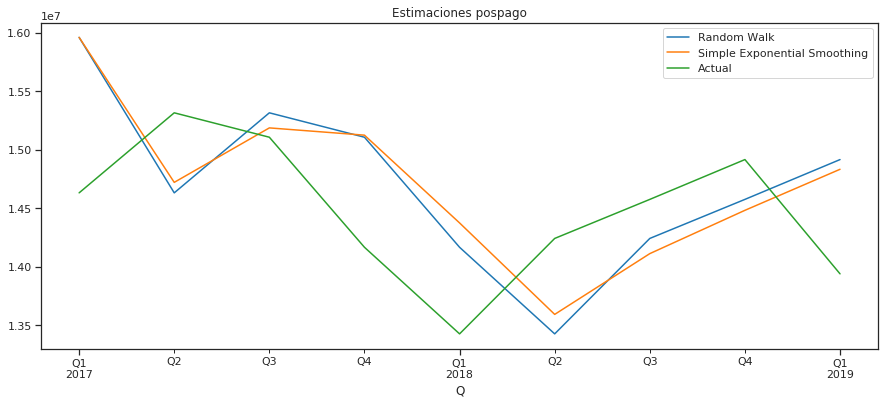

In [51]:
# ## Model validation (y2: prepago)
# 
# We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

# Real time forecasting - use it as a template - expanding window

validation2 = y2[validation_starts:].index # the validation period is Q1 2004 onwards
start2 = y2.index.get_loc(validation_starts) # numerical index corresponding to Q1 2005

pred2_1 = []
pred2_2 = []
actual2 = []
for i in range(start2, len(y2)):
    actual2.append(y2.iloc[i]) # actual value
    pred2_1.append(y2.iloc[i-1]) # random walk forecast
    model2 = sm.tsa.SimpleExpSmoothing(y2.iloc[:i]).fit() 
    pred2_2.append(model2.forecast(1)[0]) # SES forecast

columns2 = ['Random Walk', 'Simple Exponential Smoothing', 'Actual']
results_sm2 = np.vstack([pred2_1, pred2_2, actual2]).T
results_sm2 = pd.DataFrame(results_sm2, columns=columns2, index=validation2)
print(results_sm2.round(2))
print('We find that RANDOM WALK generates more accurate forecasts. ')
results_sm1.plot.line(figsize=(15,6), title='Estimaciones pospago', label='Pospago')

In [53]:
from scipy import stats

table1 = pd.DataFrame(0.0, index=results_sm1.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table1.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm1.iloc[:,i], results_sm1.iloc[:,-1])
    table1.iloc[i,1] = (results_sm1.iloc[:,i] - results_sm1.iloc[:,-1]).sem()

print(table1.round(3))

table2 = pd.DataFrame(0.0, index=results_sm2.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table2.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm2.iloc[:,i], results_sm2.iloc[:,-1])
    table2.iloc[i,1] = (results_sm2.iloc[:,i] - results_sm2.iloc[:,-1]).sem()

print(table1.round(3))

                                    RMSE          SE
Random Walk                   786660.622  266525.153
Simple Exponential Smoothing  787337.229  266217.913
                                    RMSE          SE
Random Walk                   786660.622  266525.153
Simple Exponential Smoothing  787337.229  266217.913


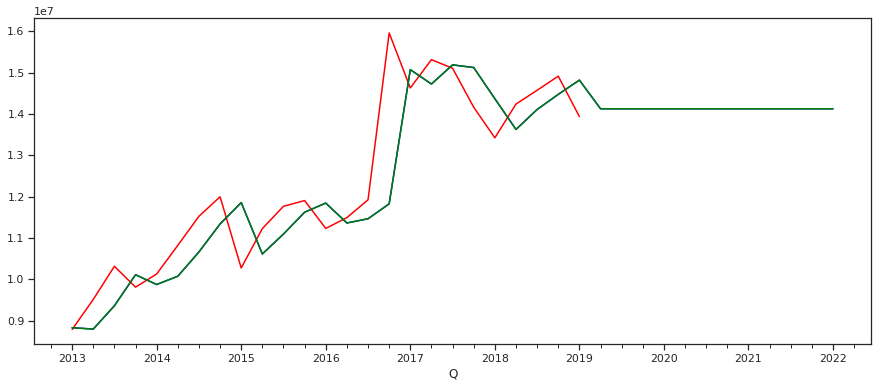

In [56]:
# ## Forecast
# 
# We show how to do expanding and rolling point forecast.

h = 12
w = h * 10
data = y1
model = sm.tsa.SimpleExpSmoothing
pred_index = data.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0, h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i == 0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues

ax = data[-w:].plot(color='red', figsize=(15,6))

pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

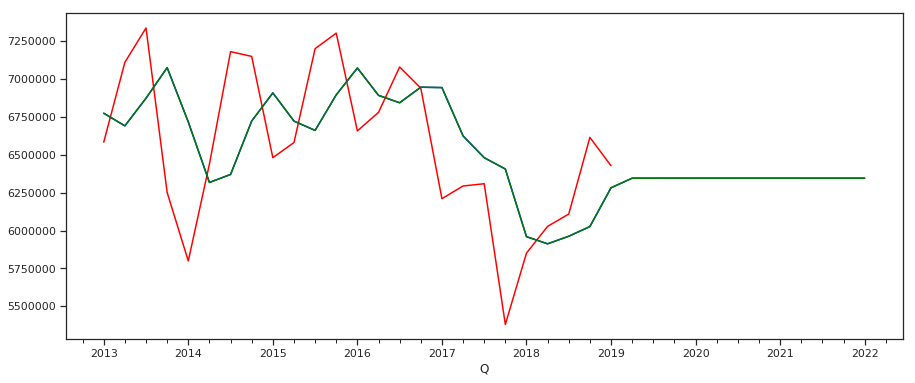

In [59]:
h = 12
w = h * 10
data = y2
model = sm.tsa.SimpleExpSmoothing
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0, h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues

ax = data[-w:].plot(color='red', figsize=(15,6))

pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');